In [3]:
#!/usr/bin/env python3
# Train a font classifier with ResNet-50 on MPS/CUDA/CPU

import os, json, math, time, random, copy
from pathlib import Path
from collections import Counter
from contextlib import nullcontext

import platform
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms

# ----------------------------
# Repro / Threads (macOS friendly)
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
try:
    torch.set_num_threads(1)
    torch.set_num_interop_threads(1)
    print("Threads set: num_threads=1, interop_threads=1")
except Exception as e:
    print(f"Could not set threads: {e}")

# ----------------------------
# Config
# ----------------------------
DATA_DIR      = "data"
OUT_DIR       = "runs/font_resnet"
BATCH_SIZE    = 32
EPOCHS        = 50                 # <-- push farther; use early stopping
WARMUP_E      = 3
VAL_SPLIT     = 0.15
LEARNING_RATE = 3e-4
WEIGHT_DECAY  = 1e-4
NUM_WORKERS   = 0
PIN_MEMORY    = False
IMG_SIZE      = 384
LOG_EVERY     = 50
PATIENCE      = 6                 # <-- early stopping patience (epochs without val improvement)

# ----------------------------
# Device
# ----------------------------
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device} | mps_available={torch.backends.mps.is_available()} | cuda={torch.cuda.is_available()}")
print("platform.machine:", platform.machine())

# ----------------------------
# Transforms
# ----------------------------
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), antialias=True),
    transforms.RandomAffine(degrees=2, translate=(0.02, 0.02), shear=(-2, 2), fill=255),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),     # <-- light photometric jitter
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize(int(IMG_SIZE*1.15), antialias=True),    # e.g. 368 when IMG_SIZE=320
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ----------------------------
# Dataset / Split
# ----------------------------
base_ds     = datasets.ImageFolder(DATA_DIR)  # no transform here
num_classes = len(base_ds.classes)
assert num_classes > 1, "Need at least 2 classes under DATA_DIR"
print("Classes:", base_ds.classes)

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
with open(Path(OUT_DIR) / "classes.json", "w") as f:
    json.dump(base_ds.classes, f)

n_total = len(base_ds); assert n_total > 0, "No images found under DATA_DIR"
n_val   = int(math.ceil(n_total * VAL_SPLIT))
n_train = n_total - n_val

g = torch.Generator().manual_seed(SEED)
perm = torch.randperm(n_total, generator=g).tolist()
train_idx, val_idx = perm[:n_train], perm[n_train:]

train_base = copy.deepcopy(base_ds); train_base.transform = train_tfms
val_base   = copy.deepcopy(base_ds); val_base.transform   = val_tfms

train_ds = Subset(train_base, train_idx)
val_ds   = Subset(val_base,   val_idx)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, persistent_workers=False
)
print(f"Samples | train: {len(train_ds)}  val: {len(val_ds)}")
print(f"Steps/epoch | train: {len(train_loader)}  val: {len(val_loader)}")

# ----------------------------
# Model (ResNet-50) + head
# ----------------------------
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features, num_classes))
model.to(device)

# ----------------------------
# Loss
# ----------------------------
criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)

# ----------------------------
# Optimizers
# ----------------------------
def make_optimizer(trainable_params, lr=LEARNING_RATE):
    return optim.AdamW(trainable_params, lr=lr, weight_decay=WEIGHT_DECAY)

# NEW: discriminative LRs (smaller for backbone, larger for head) for fine-tuning
def make_optimizer_dd(model, base_lr=1e-4, head_lr=3e-4, wd=1e-4):
    head, body = [], []
    for n, p in model.named_parameters():
        (head if n.startswith("fc") else body).append(p)
    return optim.AdamW(
        [{"params": body, "lr": base_lr},
         {"params": head, "lr": head_lr}],
        weight_decay=wd
    )

# ----------------------------
# Freeze/Unfreeze helpers
# ----------------------------
def freeze_backbone_keep_head(m: nn.Module):
    for p in m.parameters():
        p.requires_grad = False
    for p in m.fc.parameters():
        p.requires_grad = True

def unfreeze_all(m: nn.Module):
    for p in m.parameters():
        p.requires_grad = True

# NEW: keep BN from updating running stats during warmup
def set_bn_eval(m: nn.Module):
    for mod in m.modules():
        if isinstance(mod, nn.BatchNorm2d):
            mod.eval()

# ----------------------------
# Warmup (head only)
# ----------------------------
freeze_backbone_keep_head(model)
optimizer = make_optimizer(filter(lambda p: p.requires_grad, model.parameters()))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ----------------------------
# AMP (CUDA only)
# ----------------------------
use_cuda_amp = (device.type == "cuda")
scaler = torch.amp.GradScaler('cuda', enabled=use_cuda_amp)
def autocast_ctx():
    return torch.amp.autocast('cuda', dtype=torch.float16) if use_cuda_amp else nullcontext()

# ----------------------------
# Train / Eval loops
# ----------------------------
best_val_acc = 0.0
no_improve = 0
best_ckpt = Path(OUT_DIR) / "best.ckpt.pt"

def run_epoch(loader, train=True, log_every=LOG_EVERY, max_grad_norm=1.0, freeze_bn=False):
    model.train(mode=train)
    if train and freeze_bn:
        set_bn_eval(model)  # keep BN running stats fixed during warmup
    running_loss, correct, total = 0.0, 0, 0

    outer_ctx = nullcontext() if train else torch.no_grad()
    with outer_ctx:
        for i, (images, targets) in enumerate(loader):
            images = images.to(device, non_blocking=True).contiguous()
            targets = targets.to(device, non_blocking=True)

            with torch.set_grad_enabled(train):
                with autocast_ctx():
                    outputs = model(images)
                    loss = criterion(outputs, targets)

                if train:
                    optimizer.zero_grad(set_to_none=True)
                    if use_cuda_amp:
                        scaler.scale(loss).backward()
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                        optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == targets).sum().item()
            total   += targets.size(0)

            if log_every and ((i + 1) % log_every == 0):
                avg = running_loss / max(1, total)
                print(f"  [{i+1}/{len(loader)}] running_avg_loss={avg:.4f}")

    avg_loss = running_loss / total if total else 0.0
    acc = correct / total if total else 0.0
    return avg_loss, acc

# ----------------------------
# Train
# ----------------------------
for epoch in range(EPOCHS):
    t0 = time.time()

    # Warmup: freeze BN stats
    freeze_bn_now = (epoch < WARMUP_E)

    # Unfreeze at the start of epoch WARMUP_E
    if epoch == WARMUP_E:
        print(f"Unfreezing all layers at epoch {epoch}...")
        unfreeze_all(model)
        optimizer = make_optimizer_dd(model)  # <-- discriminative LRs
        remaining = max(1, EPOCHS - epoch)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=remaining)

    train_loss, train_acc = run_epoch(train_loader, train=True, freeze_bn=freeze_bn_now)
    val_loss, val_acc     = run_epoch(val_loader,   train=False)
    scheduler.step()  # called AFTER optimizer.step() happened inside the epoch

    dt = time.time() - t0
    print(f"Epoch {epoch+1:02d}/{EPOCHS} | "
          f"train_loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val_loss {val_loss:.4f} acc {val_acc:.3f} | {dt:.1f}s")

    # checkpoint + early stopping
    if val_acc > best_val_acc:
        best_val_acc, no_improve = val_acc, 0
        torch.save({
            "model_state": model.state_dict(),
            "classes": base_ds.classes,
            "val_acc": val_acc
        }, best_ckpt)
        print(f"  ✅ Saved new best to {best_ckpt} (val_acc={val_acc:.3f})")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"⏹️ Early stop: no val improvement for {PATIENCE} epochs.")
            break

print(f"Best val acc: {best_val_acc:.3f}")

# ----------------------------
# Per-class accuracies on val set
# ----------------------------
model.eval()
correct_per, total_per = Counter(), Counter()
with torch.no_grad():
    for imgs, t in val_loader:
        imgs = imgs.to(device).contiguous()
        o = model(imgs).argmax(1).cpu()
        for ti, pi in zip(t, o):
            total_per[int(ti)] += 1
            correct_per[int(ti)] += int(pi == ti)

per_class_acc = { base_ds.classes[k]: (correct_per[k] / total_per[k] if total_per[k] > 0 else 0.0)
                  for k in total_per }
print("Per-class accuracy:", per_class_acc)


Could not set threads: Error: cannot set number of interop threads after parallel work has started or set_num_interop_threads called
Using device: mps | mps_available=True | cuda=False
platform.machine: arm64
Classes: ['Inter', 'Lato', 'Merriweather', 'Montserrat', 'Nunito', 'Open_Sans', 'Oswald', 'Playfair_Display', 'Poppins', 'Raleway', 'Roboto', 'Roboto_Condensed', 'Roboto_Mono', 'Source_Sans_Pro', 'Ubuntu']
Samples | train: 6375  val: 1125
Steps/epoch | train: 200  val: 36
  [50/200] running_avg_loss=2.7125
  [100/200] running_avg_loss=2.6982
  [150/200] running_avg_loss=2.6821
  [200/200] running_avg_loss=2.6702
Epoch 01/50 | train_loss 2.6702 acc 0.121 | val_loss 2.6152 acc 0.188 | 75.8s
  ✅ Saved new best to runs/font_resnet/best.ckpt.pt (val_acc=0.188)
  [50/200] running_avg_loss=2.5874
  [100/200] running_avg_loss=2.5908
  [150/200] running_avg_loss=2.5866
  [200/200] running_avg_loss=2.5770
Epoch 02/50 | train_loss 2.5770 acc 0.205 | val_loss 2.5500 acc 0.184 | 75.9s
  [50/20

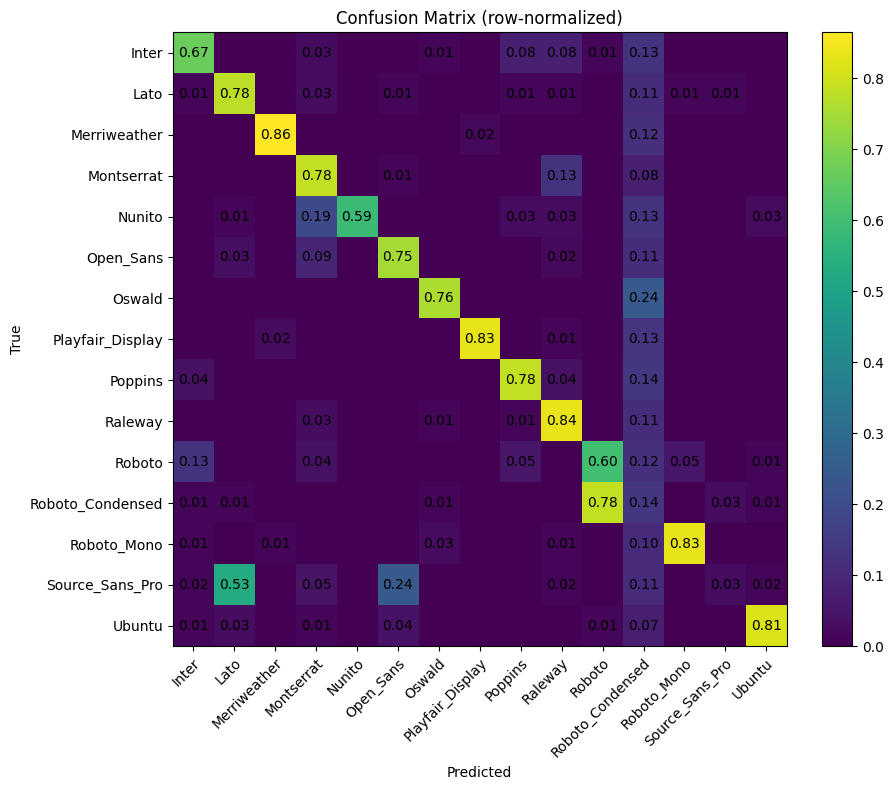

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# --- collect preds/targets ---
model.eval()
all_t, all_p = [], []
with torch.no_grad():
    for imgs, t in val_loader:
        preds = model(imgs.to(device)).argmax(1).cpu().numpy()
        all_p.append(preds)
        all_t.append(t.numpy())
all_p = np.concatenate(all_p)
all_t = np.concatenate(all_t)

classes = base_ds.classes  # or full_ds.classes
labels  = np.arange(len(classes))

# --- confusion matrix ---
cm = confusion_matrix(all_t, all_p, labels=labels)

# toggle normalization
normalize = True
if normalize:
    with np.errstate(invalid="ignore", divide="ignore"):
        cm_plot = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_plot = np.nan_to_num(cm_plot)
    fmt = ".2f"
    title = "Confusion Matrix (row-normalized)"
else:
    cm_plot = cm
    fmt = "d"
    title = "Confusion Matrix (counts)"

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm_plot, interpolation="nearest")  # default colormap
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    xlabel="Predicted",
    ylabel="True",
    title=title,
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotate cells
thresh = cm_plot.max() / 2.0
for i in range(cm_plot.shape[0]):
    for j in range(cm_plot.shape[1]):
        val = cm_plot[i, j]
        text = f"{val:{fmt}}"
        # skip tiny normalized values to reduce clutter
        if normalize and val < 0.005:
            text = ""
        ax.text(j, i, text, ha="center", va="center")

plt.tight_layout()
plt.show()

